# Task 2 Multiclass classification Baseline

In this class, we will develop a baseline for Task 2 using the chess dataset. We will model the task as an multiclass classification task.

In [1]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2, json
from torch import nn
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import models
from torchvision.transforms import v2 as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image

random.seed(42)

### Connect Colab to Drive (if the dataset is on drive)

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#!unzip "drive/MyDrive/Dataset/images.zip" -d "."
#!cp "drive/MyDrive/Dataset/annotations.json" -d "."

In [4]:
# Define the model
# Define model
#weights = models.ResNet50_Weights.IMAGENET1K_V2
#model = models.resnet50(weights=weights)
#transforms = weights.transforms()
weights = models.EfficientNet_V2_S_Weights.IMAGENET1K_V1
model = models.efficientnet_v2_s(weights=weights)
transforms = weights.transforms()

## Load dataset

**Tip**: since the images are very big, resize the dataset before loading it to save time and memory during training (use cubic interpolation to preserve image quality when downsizing the images)!

In [5]:
# Normalize images
data_aug = transforms
"""transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])"""

data_in = transforms
"""transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])"""

'transforms.Compose([\n    transforms.ToImage(),\n    transforms.Resize((256, 256)),\n    transforms.CenterCrop((224, 224)),\n    transforms.ToDtype(torch.float32, scale=True),\n    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])\n])'

In [6]:
def chesspos2number(chesspos):
    col = ord(chesspos[0])-ord('a')
    col = 7-col
    row = int(chesspos[1])-1
    return row, col

class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))
        self.categories = [c['name'] for c in self.anns['categories']]
        self.root = root_dir
        self.ids = []
        self.file_names = []
        for x in self.anns['images']:
            self.file_names.append(x['path'])
            self.ids.append(x['id'])
        self.file_names = np.asarray(self.file_names)
        #restrict ther the number of filenames to 10
        self.ids = np.asarray(self.ids)
        self.boards=torch.full((len(self.file_names), 8 * 8), 12)
        for piece in self.anns['annotations']['pieces']:
            idx = np.where(self.ids == piece['image_id'])[0][0]
            row, col = chesspos2number(piece['chessboard_position'])
            piceId =piece['category_id']
            self.boards[idx][row*8+col] = piceId
        #print(self.boards[0])
        if partition == 'train':#['chessred2k']
            self.split_ids = np.asarray(self.anns['splits']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['test']['image_ids']).astype(int)

        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.file_names = self.file_names#[:30]
        #self.boards = self.boards[self.split_ids]
        self.ids = self.ids[self.split_ids]

        self.transform = transform
        print(f"Number of {partition} images: {len(self.file_names)}")
        self.images = {}
        for i in range(len(self.file_names)):
            if i %1000 ==0:
                print(f"Loading image {i+1}/{len(self.file_names)}")
            #image = cv2.imread(os.path.join(self.root, self.file_names[i]))
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.open(os.path.join(self.root, self.file_names[i]))
            if self.transform:
                image = self.transform(image)
            self.images[self.file_names[i]] = image

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        image = self.images[self.file_names[i]]

        board = self.boards[self.split_ids[i]]
        #print("Board shape:",board.shape)
        return image, board

train_dataset = ChessDataset('..', 'train', data_aug)
valid_dataset = ChessDataset('..', 'valid', data_in)


Number of train images: 6479
Loading image 1/6479
Loading image 1001/6479
Loading image 2001/6479
Loading image 3001/6479
Loading image 4001/6479
Loading image 5001/6479
Loading image 6001/6479
Number of valid images: 2192
Loading image 1/2192
Loading image 1001/2192
Loading image 2001/2192


In [7]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 16
num_workers = 0 # how many processes are used to load the data

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)


Using cuda device


torch.Size([16, 384, 384, 3])
tensor([12,  5,  1, 12,  4,  1, 12, 12,  0,  0,  0, 12,  3, 12,  0, 12, 12, 12,
         2,  0,  3,  2, 12,  0, 12, 12, 12, 12,  0, 12, 12, 12, 12, 12, 12, 12,
         6, 12, 12,  6, 12, 12,  8, 12, 12, 12,  6, 12,  6,  6,  6,  9,  8,  6,
        12, 12, 12, 11,  7, 12, 10,  9, 12,  7])
tensor([[12,  5,  1, 12,  4,  1, 12, 12],
        [ 0,  0,  0, 12,  3, 12,  0, 12],
        [12, 12,  2,  0,  3,  2, 12,  0],
        [12, 12, 12, 12,  0, 12, 12, 12],
        [12, 12, 12, 12,  6, 12, 12,  6],
        [12, 12,  8, 12, 12, 12,  6, 12],
        [ 6,  6,  6,  9,  8,  6, 12, 12],
        [12, 11,  7, 12, 10,  9, 12,  7]])


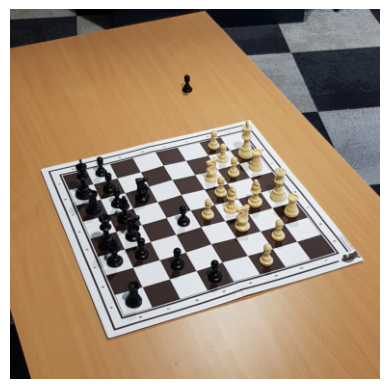

In [8]:
for batch in train_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    print(imgs.shape)

    # Get labels of each image in the batch and print them
    labels = batch[1]
    print(labels[0])
    print(labels[0].reshape(8, 8))
    #print(torch.argmax(labels[0])+1)

    # Show first image of the batch
    plt.imshow(imgs[0])
    plt.axis('off')
    plt.show()

    break

## Defining the model

We will use a pre-trained ResNet50 network.

  1: white-pawn
  2: white-pawn
  3: white-pawn
  4: white-pawn
  5: white-pawn
  6: white-pawn
  7: white-pawn
  8: white-pawn
  9: white-rook
  10: white-rook
  11: white-knight
  12: white-knight
  13: white-bishop
  14: white-bishop
  15: white-queen
  16: white-king
  17: black-pawn
  18: black-pawn
  19: black-pawn
  20: black-pawn
  21: black-pawn
  22: black-pawn
  23: black-pawn
  24: black-pawn
  25: black-rook
  26: black-rook
  27: black-knight
  28: black-knight
  29: black-bishop
  30: black-bishop
  31: black-king
  32: black-queen
  12: empty

In [9]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


#for param in model:
#    param.requires_grad = False
# change the number of neurons in the last layer to the number of classes of the problem at hand (maximum number of pieces on a chess game)
# TODO
# MLP
size_parameters = 512
print(model.classifier)
model.classifier  = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, size_parameters),
    nn.ReLU(),
    nn.Linear(size_parameters, size_parameters),
    nn.ReLU(),
    nn.Linear(size_parameters, size_parameters),
    nn.ReLU(),
    nn.Linear(size_parameters, 64),
    nn.Sigmoid()
)
# black 
model.to(device)

Using cuda device
Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

## Train the model

Define function to perform one iteration

In [10]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, f1_score,accuracy_score

def calculate_chess_accuracy(y_true, y_pred):
    """
    Calculate chess board accuracy metrics
    Args:
        y_true: Ground truth (batch_size, 64)
        y_pred: Model predictions (batch_size, 64)
    Returns:
        overall_acc: Total accuracy across all squares
        square_acc: List of accuracies per square
    """
    # Convert -0 to 0 (equivalent in floating point)
    y_true = np.where(y_true == -0., 0., y_true)
    y_pred = np.where(y_pred == -0., 0., y_pred)
    
    # Binarize predictions if using raw outputs
    y_pred = (y_pred > 0.5).astype(float)
    
    # Calculate overall accuracy (all squares combined)
    overall_acc = accuracy_score(y_true.flatten(), y_pred.flatten())
    
    # Calculate accuracy per square
    square_acc = []
    for square_idx in range(64):
        acc = accuracy_score(y_true[:, square_idx], y_pred[:, square_idx])
        square_acc.append(acc)
    
    return overall_acc, square_acc

def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device).float() # remove the last dimension
        
          # Compute prediction error
          
          pred = model(X)
          scaled_pred = (pred * 12)#.round() # Scale [0,1] → [1,32] and round
          #scaled_pred = model(X)
          #print(scaled_pred.shape,y.shape)
          #print(scaled_pred,y)
          loss = loss_fn(scaled_pred, y)

          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          preds.extend(scaled_pred.cpu())
          #print(preds)
          #print(final_pred.cpu().numpy())
          #original_values =y.cpu().argmax(dim=-1) + 1
          labels.extend(y.cpu())
    all_preds = torch.cat(preds).round()
    all_labels = torch.cat(labels)
    # Suggested fix:
    matches = (all_preds == all_labels).cpu().numpy()
    accuracy = np.mean(matches) * 100
    #print("Mean Correct: :",matches)
    """print(all_preds.shape,all_labels.shape)
    print(all_preds,all_labels)
      # Calculate exact match accuracy (PyTorch way)
    exact_matches = (all_preds == all_labels).all(dim=1).float().mean().item()
    
    # Calculate element-wise accuracy
    element_acc = (all_preds == all_labels).float().mean().item()
    print(exact_matches,element_acc)"""
    
    return total_loss / num_batches, accuracy

Define function to train a model

In [11]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
  train_history = {'loss': [], 'accuracy': []}
  val_history = {'loss': [], 'accuracy': []}
  best_val_loss = np.inf
  print("Start training...")
  for t in range(num_epochs):
      print(f"\nEpoch {t+1}")
      train_loss, train_acc = epoch_iter(train_dataloader, model, loss_fn, optimizer)
      print(f"Train loss: {train_loss:.5f} \t Train acc: {train_acc:.5f}")
      val_loss, val_acc = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
      print(f"Val loss: {val_loss:.5f} \t Val acc: {val_acc:.5f}")

      # save model when val loss improves
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_name + '_best_model.pth')

      # save latest model
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, model_name + '_latest_model.pth')

      # save training history for plotting purposes
      train_history["loss"].append(train_loss)
      train_history["accuracy"].append(train_acc)

      val_history["loss"].append(val_loss)
      val_history["accuracy"].append(val_acc)
      
  print("Finished")
  return train_history, val_history

In [12]:
test = [1, 2, 3]
test1 = [1, 0, 0]

# Create boolean array of matches
condition_array = np.array(test) == np.array(test1)

# Calculate percentage of correct elements
percentage_correct = np.mean(condition_array) * 100

print("Matching elements array:", condition_array)
print(f"Percentage correct: {percentage_correct:.1f}%")

Matching elements array: [ True False False]
Percentage correct: 33.3%


Define loss, optimizer and train the model

In [ ]:
# Define loss function
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
num_epochs = 100

# TODO - Train the model
train_history, val_history = train(model, 'chess_model', num_epochs, train_dataloader, valid_dataloader, loss_fn, optimizer)

Start training...

Epoch 1


100%|██████████| 404/404 [02:17<00:00,  2.94it/s]


Train loss: 13.04780 	 Train acc: 14.38399


100%|██████████| 137/137 [00:19<00:00,  6.96it/s]


Val loss: 11.63373 	 Val acc: 24.78045

Epoch 2


100%|██████████| 404/404 [02:11<00:00,  3.06it/s]


Train loss: 11.94054 	 Train acc: 16.74950


100%|██████████| 137/137 [00:28<00:00,  4.83it/s]


Val loss: 11.81650 	 Val acc: 12.26406

Epoch 3


100%|██████████| 404/404 [02:11<00:00,  3.08it/s]


Train loss: 11.28301 	 Train acc: 19.60836


100%|██████████| 137/137 [00:20<00:00,  6.83it/s]


Val loss: 11.11008 	 Val acc: 25.50967

Epoch 4


100%|██████████| 404/404 [02:23<00:00,  2.82it/s]


Train loss: 10.00282 	 Train acc: 24.68866


100%|██████████| 137/137 [00:20<00:00,  6.57it/s]


Val loss: 11.06983 	 Val acc: 28.71236

Epoch 5


100%|██████████| 404/404 [02:22<00:00,  2.84it/s]


Train loss: 8.50959 	 Train acc: 30.96332


100%|██████████| 137/137 [00:20<00:00,  6.71it/s]


Val loss: 10.51070 	 Val acc: 34.44414

Epoch 6


100%|██████████| 404/404 [02:24<00:00,  2.80it/s]


Train loss: 6.97023 	 Train acc: 38.76276


100%|██████████| 137/137 [00:21<00:00,  6.49it/s]


Val loss: 10.60120 	 Val acc: 34.26736

Epoch 7


100%|██████████| 404/404 [02:18<00:00,  2.92it/s]


Train loss: 5.78343 	 Train acc: 44.86676


100%|██████████| 137/137 [00:20<00:00,  6.54it/s]


Val loss: 10.17189 	 Val acc: 36.15705

Epoch 8


100%|██████████| 404/404 [02:24<00:00,  2.79it/s]


Train loss: 4.87936 	 Train acc: 49.76166


100%|██████████| 137/137 [00:21<00:00,  6.38it/s]


Val loss: 9.91609 	 Val acc: 40.32704

Epoch 9


100%|██████████| 404/404 [02:19<00:00,  2.89it/s]


Train loss: 4.31931 	 Train acc: 52.87361


100%|██████████| 137/137 [00:20<00:00,  6.65it/s]


Val loss: 10.17467 	 Val acc: 39.63775

Epoch 10


100%|██████████| 404/404 [02:26<00:00,  2.76it/s]


Train loss: 3.77037 	 Train acc: 56.02737


100%|██████████| 137/137 [00:21<00:00,  6.41it/s]


Val loss: 10.12113 	 Val acc: 43.18972

Epoch 11


100%|██████████| 404/404 [02:20<00:00,  2.87it/s]


Train loss: 3.38732 	 Train acc: 58.13327


100%|██████████| 137/137 [00:21<00:00,  6.50it/s]


Val loss: 10.07871 	 Val acc: 44.00163

Epoch 12


100%|██████████| 404/404 [02:28<00:00,  2.72it/s]


Train loss: 3.11103 	 Train acc: 59.67377


100%|██████████| 137/137 [00:21<00:00,  6.38it/s]


Val loss: 10.17537 	 Val acc: 45.10364

Epoch 13


100%|██████████| 404/404 [02:18<00:00,  2.92it/s]


Train loss: 2.93277 	 Train acc: 60.85846


100%|██████████| 137/137 [00:20<00:00,  6.60it/s]


Val loss: 9.98618 	 Val acc: 43.76497

Epoch 14


100%|██████████| 404/404 [02:22<00:00,  2.83it/s]


Train loss: 2.80269 	 Train acc: 61.84275


100%|██████████| 137/137 [00:21<00:00,  6.43it/s]


Val loss: 9.88666 	 Val acc: 44.47137

Epoch 15


100%|██████████| 404/404 [02:20<00:00,  2.88it/s]


Train loss: 2.52766 	 Train acc: 63.39172


100%|██████████| 137/137 [00:20<00:00,  6.55it/s]


Val loss: 9.87059 	 Val acc: 45.15711

Epoch 16


100%|██████████| 404/404 [02:17<00:00,  2.95it/s]


Train loss: 2.30818 	 Train acc: 64.57689


100%|██████████| 137/137 [00:20<00:00,  6.68it/s]


Val loss: 9.73040 	 Val acc: 46.22776

Epoch 17


100%|██████████| 404/404 [02:18<00:00,  2.92it/s]


Train loss: 2.20819 	 Train acc: 65.46836


100%|██████████| 137/137 [00:19<00:00,  6.87it/s]


Val loss: 9.92594 	 Val acc: 46.92347

Epoch 18


100%|██████████| 404/404 [02:16<00:00,  2.95it/s]


Train loss: 2.08617 	 Train acc: 66.05019


100%|██████████| 137/137 [00:23<00:00,  5.93it/s]


Val loss: 9.76896 	 Val acc: 45.74518

Epoch 19


100%|██████████| 404/404 [02:19<00:00,  2.89it/s]


Train loss: 2.00910 	 Train acc: 66.44372


100%|██████████| 137/137 [00:20<00:00,  6.64it/s]


Val loss: 9.67611 	 Val acc: 44.64174

Epoch 20


100%|██████████| 404/404 [02:17<00:00,  2.94it/s]


Train loss: 1.93734 	 Train acc: 66.85465


100%|██████████| 137/137 [00:20<00:00,  6.55it/s]


Val loss: 9.66239 	 Val acc: 46.32399

Epoch 21


100%|██████████| 404/404 [02:16<00:00,  2.96it/s]


Train loss: 1.86664 	 Train acc: 67.38305


100%|██████████| 137/137 [00:20<00:00,  6.60it/s]


Val loss: 9.59181 	 Val acc: 47.09669

Epoch 22


100%|██████████| 404/404 [02:20<00:00,  2.87it/s]


Train loss: 1.73063 	 Train acc: 68.24190


100%|██████████| 137/137 [00:19<00:00,  6.95it/s]


Val loss: 9.62921 	 Val acc: 46.61268

Epoch 23


100%|██████████| 404/404 [02:16<00:00,  2.96it/s]


Train loss: 1.62015 	 Train acc: 68.87231


100%|██████████| 137/137 [00:20<00:00,  6.74it/s]


Val loss: 9.66201 	 Val acc: 46.17644

Epoch 24


100%|██████████| 404/404 [02:17<00:00,  2.93it/s]


Train loss: 1.55560 	 Train acc: 69.40580


100%|██████████| 137/137 [00:20<00:00,  6.66it/s]


Val loss: 9.50259 	 Val acc: 46.76736

Epoch 25


100%|██████████| 404/404 [02:18<00:00,  2.93it/s]


Train loss: 1.54331 	 Train acc: 69.41982


100%|██████████| 137/137 [00:20<00:00,  6.67it/s]


Val loss: 9.42311 	 Val acc: 47.84016

Epoch 26


100%|██████████| 404/404 [02:20<00:00,  2.88it/s]


Train loss: 1.47124 	 Train acc: 69.81020


100%|██████████| 137/137 [00:20<00:00,  6.58it/s]


Val loss: 9.36264 	 Val acc: 47.28202

Epoch 27


100%|██████████| 404/404 [02:14<00:00,  3.00it/s]


Train loss: 1.40056 	 Train acc: 70.27745


100%|██████████| 137/137 [00:20<00:00,  6.62it/s]


Val loss: 9.45686 	 Val acc: 46.74741

Epoch 28


100%|██████████| 404/404 [02:13<00:00,  3.03it/s]


Train loss: 1.34208 	 Train acc: 70.79522


100%|██████████| 137/137 [00:18<00:00,  7.51it/s]


Val loss: 9.28434 	 Val acc: 46.80799

Epoch 29


100%|██████████| 404/404 [02:12<00:00,  3.06it/s]


Train loss: 1.29171 	 Train acc: 71.19721


100%|██████████| 137/137 [00:20<00:00,  6.73it/s]


Val loss: 9.38608 	 Val acc: 46.45230

Epoch 30


100%|██████████| 404/404 [02:11<00:00,  3.07it/s]


Train loss: 1.24676 	 Train acc: 71.45053


100%|██████████| 137/137 [00:20<00:00,  6.61it/s]


Val loss: 9.30937 	 Val acc: 47.98629

Epoch 31


100%|██████████| 404/404 [02:13<00:00,  3.03it/s]


Train loss: 1.22353 	 Train acc: 71.61853


100%|██████████| 137/137 [00:19<00:00,  6.89it/s]


Val loss: 9.20162 	 Val acc: 49.68921

Epoch 32


100%|██████████| 404/404 [02:11<00:00,  3.07it/s]


Train loss: 1.17404 	 Train acc: 72.09618


100%|██████████| 137/137 [00:19<00:00,  6.99it/s]


Val loss: 9.25679 	 Val acc: 48.06969

Epoch 33


100%|██████████| 404/404 [02:16<00:00,  2.96it/s]


Train loss: 1.14044 	 Train acc: 72.40727


100%|██████████| 137/137 [00:20<00:00,  6.72it/s]


Val loss: 9.48786 	 Val acc: 46.81726

Epoch 34


100%|██████████| 404/404 [02:19<00:00,  2.90it/s]


Train loss: 1.18660 	 Train acc: 71.97725


100%|██████████| 137/137 [00:20<00:00,  6.64it/s]


Val loss: 9.42036 	 Val acc: 47.75462

Epoch 35


100%|██████████| 404/404 [02:18<00:00,  2.91it/s]


Train loss: 1.09595 	 Train acc: 72.71861


100%|██████████| 137/137 [00:20<00:00,  6.68it/s]


Val loss: 9.10773 	 Val acc: 46.95840

Epoch 36


100%|██████████| 404/404 [02:16<00:00,  2.97it/s]


Train loss: 1.02042 	 Train acc: 73.35531


100%|██████████| 137/137 [00:20<00:00,  6.72it/s]


Val loss: 9.03266 	 Val acc: 48.49666

Epoch 37


100%|██████████| 404/404 [02:17<00:00,  2.94it/s]


Train loss: 0.98749 	 Train acc: 73.75392


100%|██████████| 137/137 [00:20<00:00,  6.70it/s]


Val loss: 9.26292 	 Val acc: 47.18793

Epoch 38


100%|██████████| 404/404 [02:18<00:00,  2.93it/s]


Train loss: 0.96649 	 Train acc: 73.83054


100%|██████████| 137/137 [00:20<00:00,  6.66it/s]


Val loss: 9.08595 	 Val acc: 48.51235

Epoch 39


100%|██████████| 404/404 [02:17<00:00,  2.94it/s]


Train loss: 0.96087 	 Train acc: 73.95793


100%|██████████| 137/137 [00:20<00:00,  6.61it/s]


Val loss: 9.06898 	 Val acc: 47.78099

Epoch 40


100%|██████████| 404/404 [02:21<00:00,  2.86it/s]


Train loss: 0.94084 	 Train acc: 74.15614


100%|██████████| 137/137 [00:20<00:00,  6.62it/s]


Val loss: 8.98619 	 Val acc: 48.11032

Epoch 41


100%|██████████| 404/404 [02:18<00:00,  2.92it/s]


Train loss: 0.91881 	 Train acc: 74.44645


100%|██████████| 137/137 [00:21<00:00,  6.49it/s]


Val loss: 8.96141 	 Val acc: 47.87651

Epoch 42


100%|██████████| 404/404 [02:16<00:00,  2.96it/s]


Train loss: 0.90692 	 Train acc: 74.53396


100%|██████████| 137/137 [00:20<00:00,  6.69it/s]


Val loss: 9.05179 	 Val acc: 49.10826

Epoch 43


100%|██████████| 404/404 [02:17<00:00,  2.95it/s]


Train loss: 0.89152 	 Train acc: 74.66086


100%|██████████| 137/137 [00:20<00:00,  6.74it/s]


Val loss: 9.02734 	 Val acc: 48.95572

Epoch 44


100%|██████████| 404/404 [02:17<00:00,  2.93it/s]


Train loss: 0.84394 	 Train acc: 75.08074


100%|██████████| 137/137 [00:20<00:00,  6.68it/s]


Val loss: 8.97537 	 Val acc: 48.93790

Epoch 45


100%|██████████| 404/404 [02:16<00:00,  2.96it/s]


Train loss: 0.83406 	 Train acc: 75.23157


100%|██████████| 137/137 [00:20<00:00,  6.67it/s]


Val loss: 8.82169 	 Val acc: 49.34777

Epoch 46


100%|██████████| 404/404 [02:17<00:00,  2.93it/s]


Train loss: 0.79771 	 Train acc: 75.60334


100%|██████████| 137/137 [00:20<00:00,  6.69it/s]


Val loss: 8.87777 	 Val acc: 47.64413

Epoch 47


100%|██████████| 404/404 [02:19<00:00,  2.90it/s]


Train loss: 0.81003 	 Train acc: 75.39546


100%|██████████| 137/137 [00:20<00:00,  6.66it/s]


Val loss: 8.96010 	 Val acc: 48.92008

Epoch 48


100%|██████████| 404/404 [02:17<00:00,  2.93it/s]


Train loss: 0.78613 	 Train acc: 75.71018


100%|██████████| 137/137 [00:20<00:00,  6.65it/s]


Val loss: 8.71214 	 Val acc: 48.47385

Epoch 49


100%|██████████| 404/404 [02:17<00:00,  2.95it/s]


Train loss: 0.75111 	 Train acc: 76.08485


100%|██████████| 137/137 [00:20<00:00,  6.75it/s]


Val loss: 8.77268 	 Val acc: 48.25288

Epoch 50


100%|██████████| 404/404 [02:17<00:00,  2.93it/s]


Train loss: 0.73991 	 Train acc: 76.34277


100%|██████████| 137/137 [00:22<00:00,  6.08it/s]


Val loss: 8.90078 	 Val acc: 48.18445

Epoch 51


100%|██████████| 404/404 [02:18<00:00,  2.91it/s]


Train loss: 0.75508 	 Train acc: 76.18614


100%|██████████| 137/137 [00:19<00:00,  7.17it/s]


Val loss: 8.88350 	 Val acc: 50.54745

Epoch 52


100%|██████████| 404/404 [02:17<00:00,  2.94it/s]


Train loss: 0.76438 	 Train acc: 76.14021


100%|██████████| 137/137 [00:20<00:00,  6.57it/s]


Val loss: 8.78372 	 Val acc: 48.75898

Epoch 53


100%|██████████| 404/404 [02:16<00:00,  2.95it/s]


Train loss: 0.72410 	 Train acc: 76.46629


100%|██████████| 137/137 [00:20<00:00,  6.60it/s]


Val loss: 8.78175 	 Val acc: 47.72040

Epoch 54


100%|██████████| 404/404 [02:21<00:00,  2.86it/s]


Train loss: 0.67654 	 Train acc: 77.07834


100%|██████████| 137/137 [00:20<00:00,  6.75it/s]


Val loss: 8.79248 	 Val acc: 48.08323

Epoch 55


100%|██████████| 404/404 [02:16<00:00,  2.95it/s]


Train loss: 0.68752 	 Train acc: 76.97464


100%|██████████| 137/137 [00:20<00:00,  6.63it/s]


Val loss: 8.90777 	 Val acc: 47.68548

Epoch 56


100%|██████████| 404/404 [02:16<00:00,  2.96it/s]


Train loss: 0.70202 	 Train acc: 76.74041


100%|██████████| 137/137 [00:20<00:00,  6.59it/s]


Val loss: 8.65894 	 Val acc: 47.22214

Epoch 57


100%|██████████| 404/404 [02:18<00:00,  2.93it/s]


Train loss: 0.67168 	 Train acc: 77.31088


100%|██████████| 137/137 [00:20<00:00,  6.60it/s]


Val loss: 8.90380 	 Val acc: 47.75034

Epoch 58


100%|██████████| 404/404 [02:21<00:00,  2.85it/s]


Train loss: 0.64358 	 Train acc: 77.61376


100%|██████████| 137/137 [00:18<00:00,  7.59it/s]


Val loss: 8.74655 	 Val acc: 47.93140

Epoch 59


100%|██████████| 404/404 [02:17<00:00,  2.93it/s]


Train loss: 0.63458 	 Train acc: 77.63188


100%|██████████| 137/137 [00:20<00:00,  6.58it/s]


Val loss: 8.74731 	 Val acc: 48.11388

Epoch 60


100%|██████████| 404/404 [02:16<00:00,  2.95it/s]


Train loss: 0.63785 	 Train acc: 77.61859


100%|██████████| 137/137 [00:20<00:00,  6.60it/s]


Val loss: 8.77975 	 Val acc: 47.76032

Epoch 61


100%|██████████| 404/404 [02:20<00:00,  2.87it/s]


Train loss: 0.61895 	 Train acc: 77.92437


100%|██████████| 137/137 [00:20<00:00,  6.62it/s]


Val loss: 8.74961 	 Val acc: 48.71265

Epoch 62


100%|██████████| 404/404 [02:18<00:00,  2.91it/s]


Train loss: 0.61967 	 Train acc: 77.90406


100%|██████████| 137/137 [00:20<00:00,  6.66it/s]


Val loss: 8.69592 	 Val acc: 47.41033

Epoch 63


100%|██████████| 404/404 [02:17<00:00,  2.95it/s]


Train loss: 0.59807 	 Train acc: 78.19921


100%|██████████| 137/137 [00:20<00:00,  6.53it/s]


Val loss: 8.66813 	 Val acc: 49.66355

Epoch 64


100%|██████████| 404/404 [02:19<00:00,  2.90it/s]


Train loss: 0.60568 	 Train acc: 78.12524


100%|██████████| 137/137 [00:20<00:00,  6.60it/s]


Val loss: 8.63780 	 Val acc: 47.89362

Epoch 65


100%|██████████| 404/404 [02:21<00:00,  2.86it/s]


Train loss: 0.61400 	 Train acc: 77.99810


100%|██████████| 137/137 [00:20<00:00,  6.59it/s]


Val loss: 8.60425 	 Val acc: 48.97497

Epoch 66


100%|██████████| 404/404 [02:18<00:00,  2.92it/s]


Train loss: 0.61050 	 Train acc: 78.18954


100%|██████████| 137/137 [00:21<00:00,  6.42it/s]


Val loss: 8.60421 	 Val acc: 48.01052

Epoch 67


100%|██████████| 404/404 [02:18<00:00,  2.91it/s]


Train loss: 0.57376 	 Train acc: 78.58403


100%|██████████| 137/137 [00:19<00:00,  7.14it/s]


Val loss: 8.66797 	 Val acc: 48.82100

Epoch 68


100%|██████████| 404/404 [02:17<00:00,  2.94it/s]


Train loss: 0.55418 	 Train acc: 78.81802


100%|██████████| 137/137 [00:22<00:00,  6.21it/s]


Val loss: 8.64766 	 Val acc: 48.42609

Epoch 69


100%|██████████| 404/404 [02:27<00:00,  2.74it/s]


Train loss: 0.54761 	 Train acc: 78.95629


100%|██████████| 137/137 [00:20<00:00,  6.61it/s]


Val loss: 8.74010 	 Val acc: 48.15736

Epoch 70


  4%|▍         | 17/404 [00:05<02:06,  3.07it/s]

## Analyse training evolution

Plot loss and accuracy throughout training on train and validation data

In [ ]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

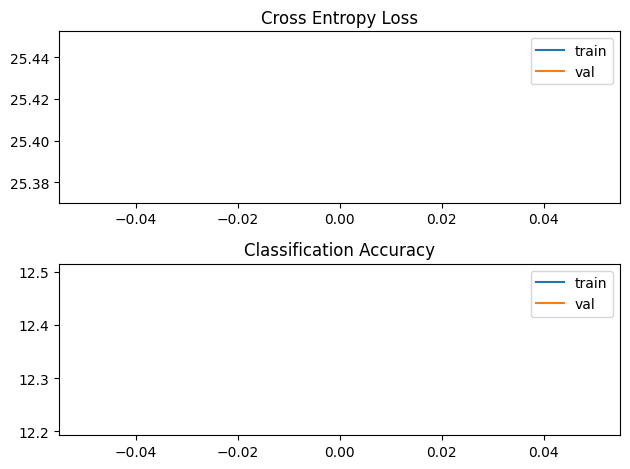

In [ ]:
plotTrainingHistory(train_history, val_history)

## Test the model

Evaluate the model in the test set

In [ ]:
# Load the best model
# TODO
del valid_dataset
del train_dataset
del valid_dataloader
del train_dataloader
test_dataset = ChessDataset('..', 'test', data_in)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
# Evaluate model on test data
# TODO
#free cuda memory
torch.cuda.empty_cache()
def test(dataloader):
    preds = []
    labels = []
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)

        #probs = F.softmax(pred, dim=1)
        #final_pred = torch.argmax(probs, dim=1)
        predsTmp = pred.cpu().detach().numpy()*12
        preds.extend(predsTmp.round().astype(int).squeeze())
        #print(pred.cpu())
        #print(y.cpu())
        original_values =y.cpu().detach().numpy()
        labels.extend(original_values)
    print(labels[:1],preds[:1])
    preds_np = np.array(preds)
    labels_np = np.array(labels)
    matches = (preds_np == labels_np)
    accuracy = np.mean(matches) * 100
    return accuracy
test_loss = test(test_dataloader)
print(f"Test loss: {test_loss:.3f}")

Number of test images: 30
Loading image 1/30


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]

[array([ 1,  2,  3,  5,  4,  3,  2,  1,  0,  0,  0,  0,  0,  0,  0,  0, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  6,  6,  6,
        6,  6,  6,  6,  6,  7,  8,  9, 11, 10,  9,  8,  7])] [array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])]
Test loss: 12.135


  0%|          | 0/2 [00:00<?, ?it/s]

[[6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6.]]
[[ 1  2  3  5  4  3  2  1]
 [ 0  0  0  0  0  0  0  0]
 [12 12 12 12 12 12 12 12]
 [12 12 12 12 12 12 12 12]
 [12 12 12 12 12 12 12 12]
 [12 12 12 12 12 12 12 12]
 [ 6  6  6  6  6  6  6  6]
 [ 7  8  9 11 10  9  8  7]]


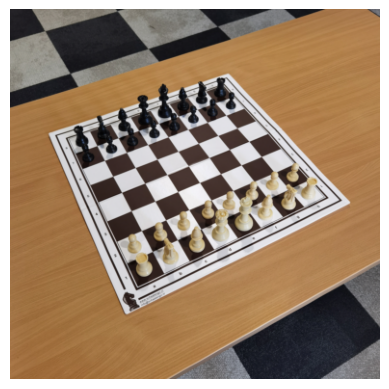

 50%|█████     | 1/2 [00:00<00:00,  3.39it/s]

[[6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6.]]
[[ 1 12 12  5  4 12 12  1]
 [ 0  0  0  3  0 12  3 12]
 [12 12  2  0 12  2 12  0]
 [12 12 12 12 12  0  0 12]
 [12 12  9 12  6 12 12 12]
 [ 6 12  8  6  9  6 12 12]
 [12  6  6 12  8 12  6  6]
 [ 7 12 12 11 10 12 12  7]]


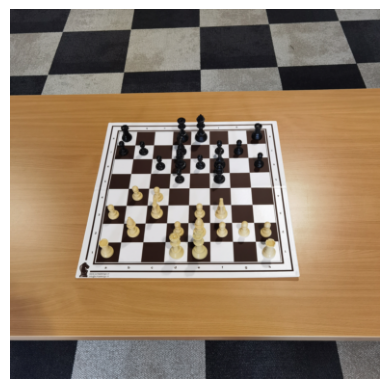

100%|██████████| 2/2 [00:01<00:00,  1.71it/s]


In [ ]:
torch.cuda.empty_cache()
def results_analyse(dataloader):
    preds = []
    labels = []
    tests = 5
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)

        #probs = F.softmax(pred, dim=1)
        #final_pred = torch.argmax(probs, dim=1)
        predsTmp = pred.cpu().detach().numpy()*12
        print(predsTmp[0].round().reshape(8, 8))
        print(y.cpu()[0].reshape(8, 8).numpy())
        #print(pred.cpu())
        #print(y.cpu())
        original_values =y.cpu()
        labels.extend(original_values)
        imgs = X.cpu()
        imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
        plt.imshow(imgs[0])
        plt.axis('off')
        plt.show()
        tests -=1
        if(tests < 0):
            break
results_analyse(test_dataloader)

## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!

## For Group Project - Task 2: Adapt multiclass classification network to regression!

Now that you have a multiclass baseline, adapt the network for the regression problem, considering the following aspects:
* How many neurons should the last layer of a regression network have?
* What should be the final activation function for a regression network?
* What loss functions can be used to train a regression network?